## 2.6 Building model with Deep Learning

## Using Tensorflow to build model

### Isolating Rossmann Store Sales dataset into time series data

In [15]:
# Importing Necessary Packages
import warnings
warnings.filterwarnings("ignore")

# import time
from datetime import date, timedelta, datetime
import numpy as np
import pandas as pd
import seaborn as sns
from pandas import datetime
from pandas import Series,DataFrame
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# data visualization
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import ticker

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing


## Setting Logging

In [5]:
import logging
import logging.handlers
import os
 
handler = logging.handlers.WatchedFileHandler(
    os.environ.get("LOGFILE", "../logs/deep_learning.log"))
formatter = logging.Formatter(logging.BASIC_FORMAT)
handler.setFormatter(formatter)
root = logging.getLogger()
root.setLevel(os.environ.get("LOGLEVEL", "INFO"))
root.addHandler(handler)
logging.info("Testing Loggings") 
try:
    exit(main())
except Exception:
    logging.exception("Exception in main()")
    exit(1)

In [6]:
# Class to load the data
class FetchData():
    def __init__(self):
        self.dfdict = {}
        self.dfdict['train'] = self.get_train_data()
        self.dfdict['test'] = self.get_test_data()
        self.dfdict['store'] = self.get_store_data()
        
    def get_train_data(self,name='train'):
        filename = f'../data/{name}.csv'
        try:
            df = pd.read_csv(filename)
            logging.info(f"{name} Dataset read successfully")
            return df

        except Exception as e:
            logging.exception(f" Exception occured in reading dataset, {e}")
            return None
    
    def get_test_data(self,name='test'):
        filename = f'../data/{name}.csv'        
        try:
            df = pd.read_csv(filename)
            logging.info(f"{name} Dataset read successfully")
            return df   

        except Exception as e:
            logging.exception(f" Exception occured in reading dataset, {e}")
            return None
        
    def get_store_data(self,name='store'):
        filename = f'../data/{name}.csv'        
        try:
            df = pd.read_csv(filename)
            logging.info(f"{name} Dataset read successfully") 
            return df  

        except Exception as e:
            logging.exception(f" Exception occured in reading dataset, {e}")
            return None 

In [7]:
data = FetchData()


In [8]:
try:
    train_data = data.get_train_data("train")
    train_store_data = data.get_train_data("train_store_data")
    test_data = data.get_train_data("test")

except Exception as e:
    logging.exception(f"Exception occured in loading dataset, Exception:{e}")

In [9]:
# temp_train_store_data.sample(4)
rossmann_store_sales = pd.DataFrame()
rossmann_store_sales['Date'] = train_data['Date']
rossmann_store_sales['Sales'] = train_data['Sales']
rossmann_store_sales.sample(4)

,Date,Sales
833407,2013-06-14,8207
82848,2015-05-18,6881
198633,2015-02-03,7945
214189,2015-01-20,3642


In [10]:
scaler = StandardScaler()
try:
    
    scale = scaler.fit(rossmann_store_sales[['Sales']]) 
    # transform the training data column
    rossmann_store_sales['Scaled_sales'] = scale.transform(rossmann_store_sales[['Sales']])
    logging.info(f"Changing non-numeric to numeric values, successfully")

except Exception as e:
    print(e)
    logging.exception(f"Exception occured while changing non-numeric to numeric values, Exception:{e}")

In [11]:
rossmann_store_sales.sample(4)

,Date,Sales,Scaled_sales
781629,2013-07-31,6596,0.213558
740049,2013-09-06,4609,-0.302556
775972,2013-08-05,7015,0.322391
336095,2014-09-16,7256,0.384990


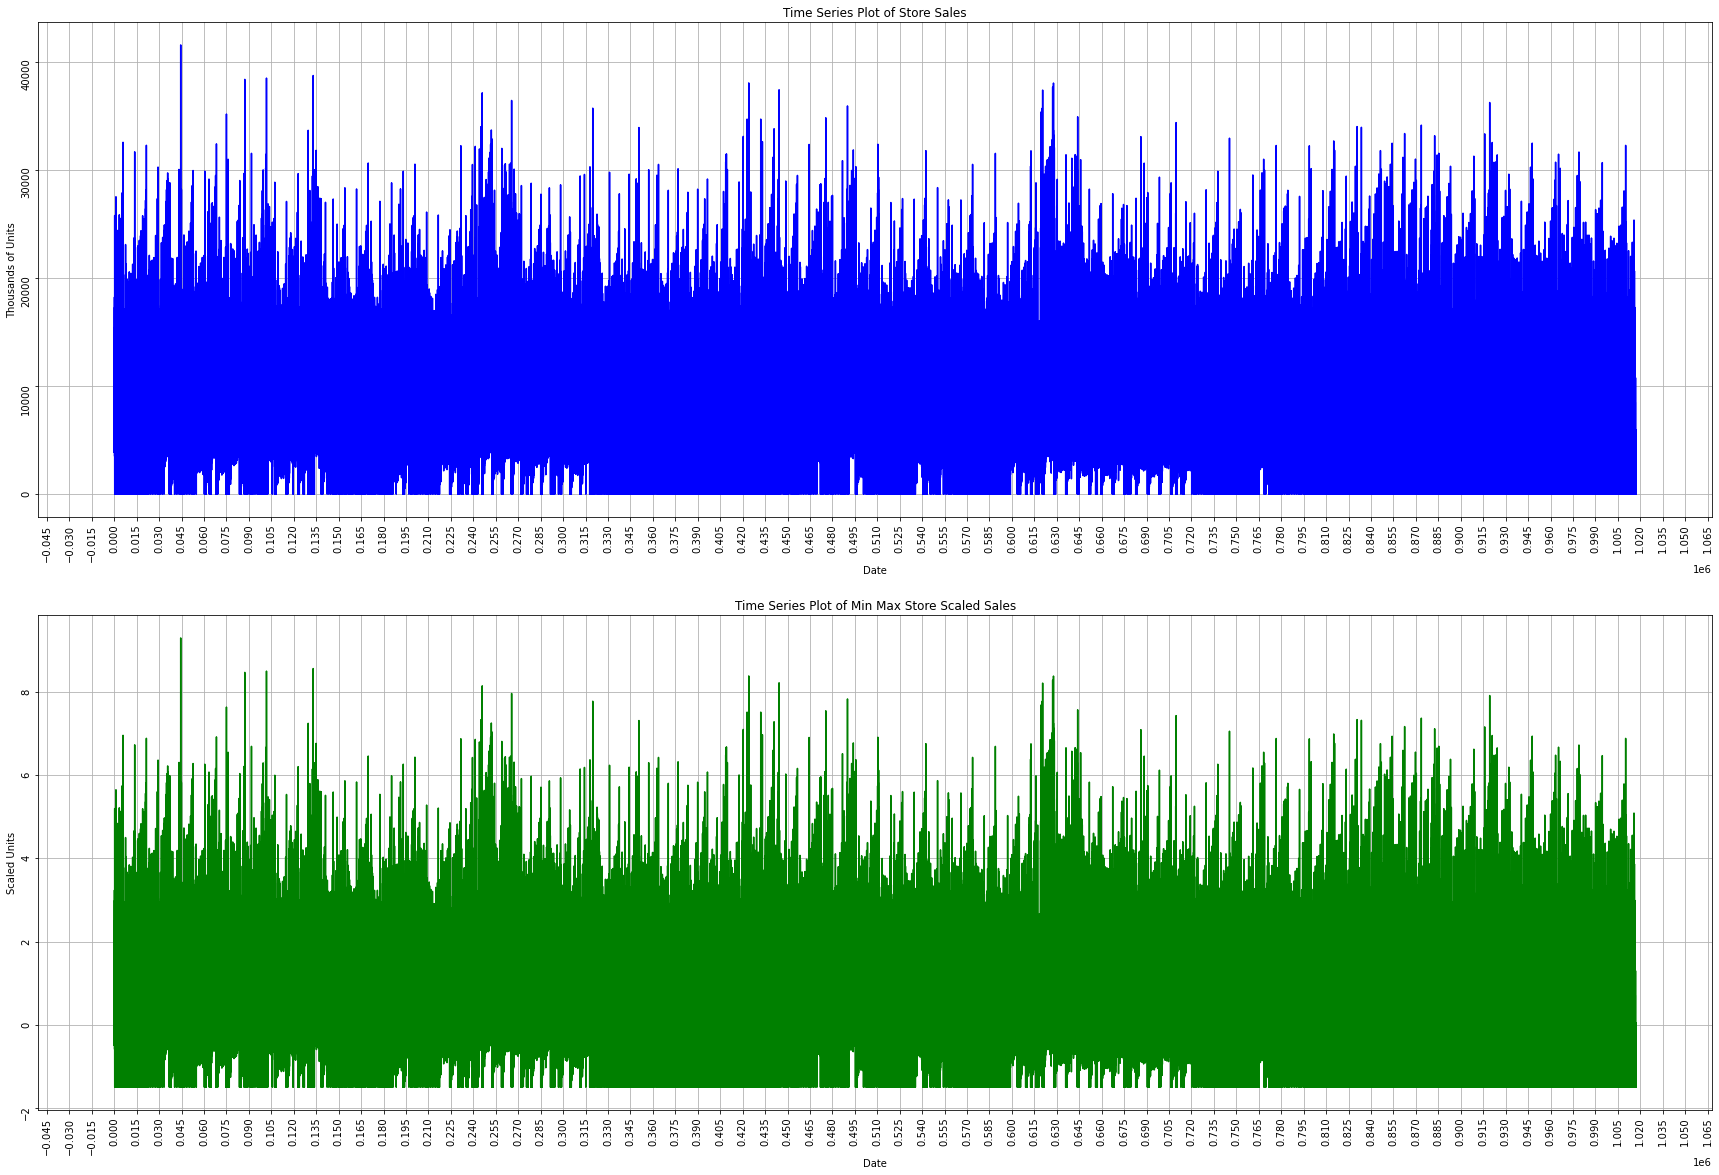

In [18]:
fig = plt.figure()
gs = GridSpec(2, 1, figure=fig)

fig.set_figheight(20)
fig.set_figwidth(30)
fig.tight_layout(pad=15)

M = 100
xticks = ticker.MaxNLocator(M)

ax1 = fig.add_subplot(gs[0,0])
ax1.plot(rossmann_store_sales.index, rossmann_store_sales.Sales, 'b-')
ax1.xaxis.set_major_locator(xticks)
ax1.tick_params(labelrotation=90)
ax1.set_xlabel('Date')
ax1.set_ylabel('Thousands of Units')
ax1.title.set_text('Time Series Plot of Store Sales')
ax1.grid(True)

ax2 = fig.add_subplot(gs[1,0])
ax2.plot(rossmann_store_sales.index, rossmann_store_sales.Scaled_sales, 'g-')
ax2.xaxis.set_major_locator(xticks)
ax2.tick_params(labelrotation=90)
ax2.set_xlabel('Date')
ax2.set_ylabel('Scaled Units')
ax2.title.set_text('Time Series Plot of Min Max Store Scaled Sales')
ax2.grid(True)
plt.show()

### Checking for Stationality

### Step 1: Check Stationarity Before going any further into our analysis, our series has to be made stationary.
 - Stationarity is the property of exhibiting constant statistical properties (mean, variance, autocorrelation etc). if the mean of a tm increases over time, then it not stationary.

### The mean across many time periods is only informative if the expected value is the same across time periods. If these population parameters can vary, what are we really estimating by taking an average across time?

### Stationarity requires that the statistical properties must be the same across time, making the sample average a reasonable way to estimate them.
### Methods to Check Stationarity
 ### 1 Plotting rolling statistics: plotting rolling mean and variance is a first good way to visually inspect our series. If the rolling statistics exhibit a clear trend (upwards or downwards) and show varying variance (increasing or decreasing amplitude), then you might conclude that the series is very likely not stationary.

 ### 2 ACF and PACF plots: An autocorrelation plot (ACF) represent the autocorrelation of the series with lags of itself. A partialACF plot represent the amount of correlation beetween a series and a lag of itself that is not explained by correlations at all lower-order lags Ideally, we want no corralation between the series and lags of itself. Graphically speaking, we would like all the spikes to fall in the blue region.

In [19]:
adfResult = adfuller(rossmann_store_sales.Sales.values, autolag='AIC')
print(f'ADF Statistic: {adfResult[0]}')
print(f'p-value: {adfResult[1]}')

## Transform the time series data into supervised learning data by creating a new y(target) column. For example as illustrated here in the Sliding Window For Time Series Data section

In [32]:
SIZE = len(rossmann_store_sales.Scaled_sales)
WINDOW_SIZE = 48
BATCH_SIZE= int(SIZE*0.8)
EPOCHS = 200

In [29]:
DateTrain = rossmann_store_sales.index.values[0:BATCH_SIZE]
DateValid = rossmann_store_sales.index.values[BATCH_SIZE:]
XTrain = rossmann_store_sales.Scaled_sales.values[0:BATCH_SIZE].astype('float32')
XValid = rossmann_store_sales.Scaled_sales.values[BATCH_SIZE:].astype('float32')

# Obtain shapes for vectors of size (,1) for dates series

DateTrain = np.reshape(DateTrain, (-1, 1))
DateValid = np.reshape(DateValid, (-1, 1))

print("Shape of the training set date series: ", DateTrain.shape)
print("Shape of the validation set date series: ", DateValid.shape)
print()
print("Shape of the training set logarithm of sales series: ", XTrain.shape)
print("Shape of the validation set logarithm of sales series in a stateless LSTM: ", XValid.shape)

Shape of the training set date series:  (813767, 1)
Shape of the validation set date series:  (203442, 1)

Shape of the training set logarithm of sales series:  (813767,)
Shape of the validation set logarithm of sales series in a stateless LSTM:  (203442,)


In [30]:
tf.random.set_seed(1234)
# add extra dimension
series = tf.expand_dims(XTrain, axis=-1)
series.shape

TensorShape([813767, 1])

In [31]:
# create tensor from each individual element
dataset = tf.data.Dataset.from_tensor_slices(series)
dataset

<TensorSliceDataset shapes: (1,), types: tf.float32>

In [33]:
# takes a window_size + 1 chunk from the slices
dataset = dataset.window(WINDOW_SIZE + 1, shift=1, drop_remainder=True) 

In [34]:
# Example of Window
datasetEx = tf.data.Dataset.from_tensor_slices(tf.range(10))
datasetEx = datasetEx.window(5, shift=1, drop_remainder=True)
for window in datasetEx:
    print([elem.numpy() for elem in window])

[0, 1, 2, 3, 4]
[1, 2, 3, 4, 5]
[2, 3, 4, 5, 6]
[3, 4, 5, 6, 7]
[4, 5, 6, 7, 8]
[5, 6, 7, 8, 9]


In [35]:
dataset = dataset.flat_map(lambda window: window.batch(WINDOW_SIZE + 1))

In [36]:
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))

In [37]:
dataset = dataset.batch(BATCH_SIZE).prefetch(1)

In [38]:
def windowed_dataset(series, window_size=WINDOW_SIZE, batch_size=BATCH_SIZE): 
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True) 
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [39]:
DatasetTrain = windowed_dataset(XTrain)
DatasetVal = windowed_dataset(XValid)

### Define and Estimate the LSTM.

In [40]:
model = Sequential()
model.add(LSTM(8, input_shape=[None, 1], return_sequences=True))
model.add(LSTM(4, input_shape=[None, 1]))
model.add(Dense(1))
model.compile(loss="huber_loss", optimizer='adam')

### The Huber loss is chosen because it is quite robust for non linear regression models and models with non normal errors.

In [41]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, None, 8)           320       
_________________________________________________________________
lstm_3 (LSTM)                (None, 4)                 208       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 533
Trainable params: 533
Non-trainable params: 0
_________________________________________________________________


In [42]:
history = model.fit(DatasetTrain, epochs=EPOCHS, validation_data=DatasetVal, verbose=1)

Epoch 1/200


In [ ]:
fig = plt.figure()
plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['val_loss'], label="val_loss")
plt.legend()
plt.show()

### Forecast the LSTM on the Validation Set and Assess Accuracy.

In [ ]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True) 
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(SIZE).prefetch(1)
  forecast = model.predict(ds)
  return forecast

In [ ]:
Forecast = model_forecast(model, rossmann_store_sales.Scaled_sales.values[:, np.newaxis], WINDOW_SIZE)
Results = Forecast[BATCH_SIZE-WINDOW_SIZE:-1]
Results1 = scaler.inverse_transform(Results.reshape(-1,1))
XValid1 = scaler.inverse_transform(XValid.reshape(-1,1))

In [ ]:
plt.figure(figsize=(30, 8))
plt.title("LSTM Model Forecast Compared to Validation Data")
plt.plot(DateValid.astype('datetime64'), Results1, label='Forecast series')
plt.plot(DateValid.astype('datetime64'), np.reshape(XValid1, (2*WINDOW_SIZE, 1)), label='Validation series')
plt.xlabel('Date')
plt.ylabel('Thousands of Units')
plt.xticks(DateValid.astype('datetime64')[:,-1], rotation = 90) 
plt.legend(loc="upper right")

MAE = tf.keras.metrics.mean_absolute_error(XValid1[:,-1], Results[:,-1]).numpy()
RMSE = np.sqrt(tf.keras.metrics.mean_squared_error(XValid1[:,-1], Results[:,-1]).numpy())

textstr = "MAE = " + "{:.3f}".format(MAE) + "  RMSE = " + "{:.3f}".format(RMSE)

# place a text box in upper left in axes coords
plt.annotate(textstr, xy=(0.87, 0.05), xycoords='axes fraction')
plt.grid(True)

plt.show()